## **Getting Dataset**

In [1]:
# Connecting with kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
#Downloading dataset
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

 96% 543M/565M [00:03<00:00, 246MB/s]
100% 565M/565M [00:03<00:00, 182MB/s]


In [3]:
# Unzipping
import zipfile
zip_ref = zipfile.ZipFile('/content/fashion-product-images-small.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
# Importing Libraries
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import GlobalMaxPooling2D
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
from numpy.linalg import norm
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import pickle

## **ResNet50 Model Creation**

In [5]:
# Used ResNet50 - Transfer Learning
model = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
model.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [6]:
# Add Maxpooling layer at the end
model = tensorflow.keras.Sequential([model,GlobalMaxPooling2D()])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
# Function for extract features from images
def extract_features(img_path,model):
  img = image.load_img(img_path,target_size=(224,224))
  img_array = image.img_to_array(img)
  expanded_img_array = np.expand_dims(img_array,axis=0)
  preprocessed_img = preprocess_input(expanded_img_array)
  result = model.predict(preprocessed_img).flatten()
  normalized_result = result/norm(result)
  return normalized_result

In [9]:
len(os.listdir('images'))

44441

In [10]:
# Function for file path - filenames
filenames = []

for file in os.listdir('images'):
  filenames.append(os.path.join('images',file))

len(filenames)

44441

In [ ]:
# Extract features from 1000 images
feature_list = []
for file in tqdm(filenames[0:15000]):
    feature_list.append(extract_features(file, model))

In [24]:
# Shape of extracted images
feature_list = np.array(feature_list)
feature_list.shape

(15000, 2048)

In [25]:
# Dumping feature list & filenames for future use
pickle.dump(feature_list,open('embeddings.pkl','wb'))
pickle.dump(filenames,open('filenames.pkl','wb'))

## **Testing The Results**

In [26]:
# Extracting the features of test image
sample_img_features = extract_features('/content/t shirt.jpg',model)

1/1 [==============================] - 0s 29ms/step


In [27]:
# Finding nearest Neighbours of uploaded image file
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5,algorithm='brute',metric='euclidean')
neighbors.fit(feature_list)

distances,indices = neighbors.kneighbors([sample_img_features])
print(indices)

for file in indices[0]:
  print(filenames[file])

[[ 9882  6448   883 14157  9582]]
images/45659.jpg
images/29629.jpg
images/18889.jpg
images/1972.jpg
images/13793.jpg


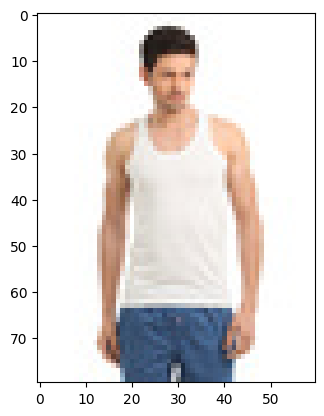

In [28]:
# Showing Images
import cv2
import matplotlib.pyplot as plt
test_img = cv2.imread('images/45659.jpg')
rgb_image = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)

## **Streamlit Application**

In [29]:
!pip install streamlit -q

In [36]:
# Creating app file
%%writefile app.py

# Importing Libraries -------------------------
import streamlit as st
import os
from PIL import Image
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import GlobalMaxPooling2D
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm
import pickle
from sklearn.neighbors import NearestNeighbors

# Loading feature_list & Filenames ------------------------
feature_list = np.array(pickle.load(open('embeddings.pkl','rb')))
filenames = pickle.load(open('filenames.pkl','rb'))

#ResNet50 Model Creation -----------------------
model = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
model.trainable = False
model = tensorflow.keras.Sequential([model,GlobalMaxPooling2D()])

st.title('STYLE ADVISOR APPLICATION')

def save_uploaded_file(uploaded_file):
  try:
    with open(os.path.join('uploads',uploaded_file.name),'wb') as f:
      f.write(uploaded_file.getbuffer())
    return 1
  except:
    return 0

def feature_extraction(img_path,model):
  img = image.load_img(img_path,target_size=(224,224))
  img_array = image.img_to_array(img)
  expanded_img_array = np.expand_dims(img_array,axis=0)
  preprocessed_img = preprocess_input(expanded_img_array)
  result = model.predict(preprocessed_img).flatten()
  normalized_result = result/norm(result)
  return normalized_result

def recommend(features,feature_list):
  neighbors = NearestNeighbors(n_neighbors=5,algorithm='brute',metric='euclidean')
  neighbors.fit(feature_list)
  distances,indices = neighbors.kneighbors([features])
  return indices

uploaded_file = st.file_uploader("Choose an Image:")
if uploaded_file is not None:
  if save_uploaded_file(uploaded_file):
    display_image = Image.open(uploaded_file)
    st.image(display_image)

    features = feature_extraction(os.path.join('uploads',uploaded_file.name),model)

    indices = recommend(features,feature_list)

    st.header("Similar Products")
    columns = st.columns(5)
    with columns[0]:
        st.image(filenames[indices[0][0]], use_column_width=True)
    with columns[1]:
        st.image(filenames[indices[0][1]], use_column_width=True)
    with columns[2]:
        st.image(filenames[indices[0][2]], use_column_width=True)
    with columns[3]:
        st.image(filenames[indices[0][3]], use_column_width=True)
    with columns[4]:
        st.image(filenames[indices[0][4]], use_column_width=True)

    st.header("About Our App")
    st.write("Our Fashion Recommender uses advanced algorithms to suggest styles that match your unique preferences and taste. Discover a world of fashion like never before!")

  else:
    st.header("Some Error")

Overwriting app.py


In [37]:
!wget -q -O - ipv4.icanhazip.com

34.172.113.106


In [38]:
!streamlit run app.py & npx localtunnel --port 8501

[##................] | fetchMetadata: sill resolveWithNewModule yargs-parser@20


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.172.113.106:8501

npx: installed 22 in 3.444s
your url is: https://green-colts-juggle.loca.lt
2023-08-20 06:59:35.642602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-20 06:59:42.728155: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
1/1 [==============================] - 3s 3s/step
  Stopping...
^C
